In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

### Preparación de los datos

In [4]:
dff = pd.read_excel("FISLAC_update.xlsx", sheet_name = "Sheet1")

In [5]:
pob = pd.read_excel("POP_WB.xlsx")

In [6]:
pob['DATE'] = pd.to_datetime(pob['DATE'], format='%Y')
pob['POP'] = pd.to_numeric(pob['POP'], errors='coerce')
pob.sort_values(by=['ISO3', 'DATE'], inplace=True)
pob['POP'] = pob.groupby('ISO3')['POP'].apply(lambda x: x.interpolate())
pob['POP'] = pob.groupby('ISO3')['POP'].apply(lambda x: x.interpolate().fillna(method='bfill').fillna(method='ffill'))

<ipython-input-6-59ca4d38292b>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pob['POP'] = pob.groupby('ISO3')['POP'].apply(lambda x: x.interpolate())
<ipython-input-6-59ca4d38292b>:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pob['POP'] = pob.groupby('ISO3')['POP'].apply(lambda x: x.inter

In [7]:
pob['DATE'] = pob['DATE'].dt.year

In [38]:
explicativas = ["INTR_EXPENSES_GDP", "DEBT_AFFORTABILITY", "PRIM_BAL_GDP", "CURR_EXP_GDP"]

In [39]:
variables = explicativas + ["DEBT_GDP", "EXP_GDP", "REV_GDP",
             "WGI_CONTR_CORR", "WGI_GOV_EFFECT", "WGI_POL_STAB", "WGI_REG_QUAL", "WGI_ROL", "WGI_VOICE_ACCOUNT", 
             "TRADE_OPEN", "CONSUMPTION_PC", "NET_FDI_GDP", "BROAD_MONEY_GDP", "LUR", "CAP_RETURN", "INT_RESERVES_CAP", "INFLATION", "BANK_CRISIS", "COMDEP", "INTRES_GDP"]

fr = ["FISCAL_RULE"]
ids = ["COUNTRY_NAME", "WEO_CODE", "ISO3" , "LAC1", "LAC2", "GROUP", "REGION", "DATE"]

In [40]:
df = dff[ids + variables + fr]

fr = df[["ISO3", "DATE", "FISCAL_RULE"]]
fr = fr[df.DATE>2000]
fr = fr.groupby(["ISO3"])["FISCAL_RULE"].sum().reset_index()
fr["FISCAL_RULE"] = fr["FISCAL_RULE"].apply(lambda x: 1 if x>0 else 0)

df = df[ids + variables]

df = df.merge(fr, "left", "ISO3")
df= df[df.FISCAL_RULE==1]

df = df[ids + variables]


In [41]:
df = df.merge(pob, "left", ["DATE", "ISO3"])

In [42]:
# df = df[df.LAC2==1]

In [43]:
grupos = df[["ISO3", "REGION", "GROUP", "COUNTRY_NAME"]].drop_duplicates()

### Cluster para seleccionar pool de paises

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [45]:
dfc = df[(df.DATE>=2000) & (df.DATE<=2005)]
dfc = dfc.groupby("ISO3").mean()
dfc = dfc[variables]

dfcm = dfc.copy()
dfcm = dfcm.merge(grupos, "left", "ISO3")

dfc = pd.DataFrame(scaler.fit_transform(dfc), columns=dfc.columns, index = dfc.index)

<ipython-input-45-93b5fc6f98d6>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfc = dfc.groupby("ISO3").mean()


In [46]:
peru = dfcm[dfcm.ISO3 == "PER"].T.reset_index(); peru.columns = ["VARIABLE", "MEDIA"]
maximo_mimebros = 40

### Clustering jerárquico aglomerativo

In [47]:
linked = linkage(dfc, method='ward')

In [48]:
from scipy.cluster.hierarchy import fcluster


for i in range(1,25):
    num_clusters = i
    clusters = fcluster(linked, num_clusters, criterion='maxclust')
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"]=="PER"].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros<=maximo_mimebros:
        break

jerarquico_media = dfcm[dfcm.cluster == cluster_peru].mean().reset_index(); jerarquico_media.columns = ["VARIABLE", "JERARQUICO"]
jerarquico_media.loc[-1] = ["N", miembros]
peru = peru.merge(jerarquico_media, "outer", "VARIABLE")

jerarquico_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)

<ipython-input-48-81ad07ee62b6>:14: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  jerarquico_media = dfcm[dfcm.cluster == cluster_peru].mean().reset_index(); jerarquico_media.columns = ["VARIABLE", "JERARQUICO"]


In [49]:
# labels = dfc.index.tolist()
# plt.figure(figsize=(15, 6), dpi=200)
# dendrogram(linked, labels=labels, orientation='bottom', distance_sort='descending', show_leaf_counts=True)
# plt.title('Dendrograma del Clustering Jerárquico Aglomerativo')
# plt.ylabel('Índice de la muestra')
# plt.xlabel('Distancia')
# plt.show()

### Clustering espectral

In [50]:
from sklearn.cluster import SpectralClustering

for i in range(1,25):

    num_clusters = i
    spectral = SpectralClustering(n_clusters= num_clusters, affinity='nearest_neighbors')
    clusters = spectral.fit_predict(dfc)
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"]=="PER"].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros<=maximo_mimebros:
        break


espectral_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)

jerarquico_media = dfcm[dfcm.cluster == cluster_peru].mean().reset_index(); jerarquico_media.columns = ["VARIABLE", "ESPECTRAL"]
jerarquico_media.loc[-1] = ["N", miembros]
peru = peru.merge(jerarquico_media, "outer", "VARIABLE")
# peru = peru.merge(jerarquico_media, "left", "VARIABLE")

<ipython-input-50-9fbf6a0b1dc8>:18: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  jerarquico_media = dfcm[dfcm.cluster == cluster_peru].mean().reset_index(); jerarquico_media.columns = ["VARIABLE", "ESPECTRAL"]


### Clustering OPTICS

In [51]:
from sklearn.cluster import OPTICS


for i in range(1,25):

    optics = OPTICS(min_samples=i)
    clusters = optics.fit_predict(dfc)
    clusters
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"]=="PER"].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros<=maximo_mimebros:
        break


optics_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)

jerarquico_media = dfcm[dfcm.cluster == cluster_peru].mean().reset_index(); jerarquico_media.columns = ["VARIABLE", "OPTICS"]
jerarquico_media.loc[-1] = ["N", miembros]
peru = peru.merge(jerarquico_media, "outer", "VARIABLE")



<ipython-input-51-bb3cfba93086>:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  jerarquico_media = dfcm[dfcm.cluster == cluster_peru].mean().reset_index(); jerarquico_media.columns = ["VARIABLE", "OPTICS"]


### Clustering BIRCH

In [52]:
from sklearn.cluster import Birch


for i in range(1,25):

    birch = Birch(n_clusters=i)
    clusters = birch.fit_predict(dfc)
    clusters
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"]=="PER"].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros<=maximo_mimebros:
        break


birch_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)

jerarquico_media = dfcm[dfcm.cluster == cluster_peru].mean().reset_index(); jerarquico_media.columns = ["VARIABLE", "BIRCH"]
jerarquico_media.loc[-1] = ["N", miembros]
peru = peru.merge(jerarquico_media, "outer", "VARIABLE")


<ipython-input-52-32cd93181d58>:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  jerarquico_media = dfcm[dfcm.cluster == cluster_peru].mean().reset_index(); jerarquico_media.columns = ["VARIABLE", "BIRCH"]


### Clustering Gaussian Mixture

In [53]:
from sklearn.mixture import GaussianMixture


for i in range(1,25):

    gmm = GaussianMixture(n_components=i)
    gmm.fit(dfc)
    clusters = gmm.predict(dfc)
    clusters
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"]=="PER"].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros<=maximo_mimebros:
        break


gmm_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)

jerarquico_media = dfcm[dfcm.cluster == cluster_peru].mean().reset_index(); jerarquico_media.columns = ["VARIABLE", "GMM"]
jerarquico_media.loc[-1] = ["N", miembros]
peru = peru.merge(jerarquico_media, "outer", "VARIABLE")

<ipython-input-53-bd3b65546759>:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  jerarquico_media = dfcm[dfcm.cluster == cluster_peru].mean().reset_index(); jerarquico_media.columns = ["VARIABLE", "GMM"]


In [54]:

lista_total = jerarquico_lista + espectral_lista + optics_lista + birch_lista + gmm_lista
dfcont = pd.DataFrame(lista_total, columns=['ISO3'])
dfcont = dfcont[dfcont["ISO3"]!="PER"]; dfcont = dfcont.merge(grupos, "left", "ISO3")

# Contando la frecuencia de cada elemento y ordenándolos
frecuencias = dfcont['COUNTRY_NAME'].value_counts()/5

# # Creando un gráfico de barras
# plt.figure(figsize=(8, 10), dpi=200)
# frecuencias.plot(kind='barh')
# plt.xlabel('Frecuencia')
# plt.ylabel('País')
# plt.title('Frecuencias por país')
# # plt.xticks(rotation=70)
# plt.gca().invert_yaxis()  # Invertir el eje y para mostrar el más frecuente en la parte superior
# plt.show()

In [55]:
cluster = dfcont.groupby("ISO3").count()["COUNTRY_NAME"].reset_index(); cluster.columns = ["ISO3", "CLUSTER"]
df = df.merge(cluster, "left", "ISO3")
df["CLUSTER"] = df["CLUSTER"].fillna(0)

### Añadidura de variables

In [56]:
gdp = ['gb_gdp_a', 'gb_p_gdp_a', 'ge_gdp_a', 'gei_gdp_a', 'ge_p_gdp_a', 'gr_gdp_a', 'gr_p_gdp_a']
gdp_cap = ["FIS_BAL", "PFISC_BAL", "EXP", "EXP_INT", "P_EXP", "REV", "P_REV"]

niv = ["cpi_1990_e_a", "exr_a", "ir_a", "gdp_usd_a"]
niv_cap = ["CPI", "EXR", "IR", "GDP_USD"]

In [28]:
ugog = pd.read_excel("WEO_1990_2022_FR_20230810.xlsx")

In [29]:
ugo = ugog.copy()

In [30]:
ugo = ugo.rename(columns = {"ifscode":"WEO_CODE", "year": "DATE"})

In [31]:
ugo = ugo.drop_duplicates(["WEO_CODE", "DATE"], keep="last")

In [32]:
# ugo["gdp_usd_a"] = ugo["gdp_usd_a"]*1000000000

for i,e in zip(gdp, gdp_cap):
    # ugo = ugo.rename(columns = {i:e})

    ugo[e] = ugo[i]*ugo['gdp_usd_a']

In [33]:
for i,e in zip(niv, niv_cap):
    print(i,e)
    ugo = ugo.rename(columns = {i:e})

cpi_1990_e_a CPI
exr_a EXR
ir_a IR
gdp_usd_a GDP_USD


In [34]:
ugo = ugo[["WEO_CODE", "DATE"]+niv_cap+gdp_cap]

In [35]:
ugo = ugo.groupby('WEO_CODE').apply(lambda group: group.interpolate(method='linear'))
ugo = ugo.groupby('WEO_CODE').apply(lambda group: group.interpolate(method='linear', limit_direction='backward'))
ugo = ugo.groupby('WEO_CODE').apply(lambda group: group.interpolate(method='linear', limit_direction='forward'))

# df_interpolated = df.groupby('WEO_CODE').apply(lambda group: group.interpolate(method='linear', limit_direction='backward'))



<ipython-input-35-ef5de885cb97>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ugo = ugo.groupby('WEO_CODE').apply(lambda group: group.interpolate(method='linear'))
<ipython-input-35-ef5de885cb97>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ugo = ugo.groupby('WEO_CODE').apply(lambda group

In [36]:
df = df.merge(ugo, "left", ["WEO_CODE", "DATE"])

In [37]:
df.to_stata("dbec_vf.dta")

In [38]:
df["CPI"]

0       110.560883
1       110.560883
2       110.560883
3       110.560883
4       113.441681
           ...    
4047           NaN
4048           NaN
4049           NaN
4050           NaN
4051           NaN
Name: CPI, Length: 4052, dtype: float64

In [36]:
df[df.WEO_CODE==626
]

,COUNTRY_NAME,WEO_CODE,ISO3,LAC1,LAC2,GROUP,REGION,DATE,DEBT_GDP,EXP_GDP,...,EXR,IR,GDP_USD,FIS_BAL,PFISC_BAL,EXP,EXP_INT,P_EXP,REV,P_REV
1911,Central African Republic (the),626,CAF,0,0,EMDEs,Sub-Saharan Africa,1990,1.718502,0.220084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1912,Central African Republic (the),626,CAF,0,0,EMDEs,Sub-Saharan Africa,1991,1.610341,0.226332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1913,Central African Republic (the),626,CAF,0,0,EMDEs,Sub-Saharan Africa,1992,1.502180,0.230916,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914,Central African Republic (the),626,CAF,0,0,EMDEs,Sub-Saharan Africa,1993,1.394019,0.206257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1915,Central African Republic (the),626,CAF,0,0,EMDEs,Sub-Saharan Africa,1994,1.285858,0.223522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1916,Central African Republic (the),626,CAF,0,0,EMDEs,Sub-Saharan Africa,1995,1.177697,0.205692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1917,Central African Republic (the),626,CAF,0,0,EMDEs,Sub-Saharan Africa,1996,1.069536,0.117118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1918,Central African Republic (the),626,CAF,0,0,EMDEs,Sub-Saharan Africa,1997,0.961375,0.144603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1919,Central African Republic (the),626,CAF,0,0,EMDEs,Sub-Saharan Africa,1998,0.853214,0.180503,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920,Central African Republic (the),626,CAF,0,0,EMDEs,Sub-Saharan Africa,1999,0.841618,0.181956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# df = pd.read_csv("FISLAC_update.csv", sep = ";")

df = dff[, "DATE", "DEBT_GDP","DEMOCRACY","EXP_GDP","REV_GDP", 
         "WGI_CONTR_CORR", "WGI_GOV_EFFECT", "WGI_GOV_IND", "WGI_POL_STAB", "WGI_REG_QUAL", "WGI_ROL", "WGI_VOICE_ACCOUNT"]]
df = df[(df.DATE>=2000) & (df.DATE<=2023)]

In [48]:
dffr = pd.read_excel("Application_EC.xlsx", sheet_name="DDBB_CS") #LECTURA BASE DE CLAUSULAS
dffr = dffr.rename(columns = {"year": "DATE"})
ec = dffr.groupby(["ISO3", "DATE"])["EC"].sum().reset_index(); ec["EC"] = ec["EC"].apply(lambda x: 1 if x>0 else 0) #EXISTENCIA DE CLAUSULA
act = dffr.groupby(["ISO3", "DATE"])["ACT"].sum().reset_index(); act["ACT"] = act["ACT"].apply(lambda x: 1 if x>0 else 0) #ACTIVACIÓN CLASULA

In [49]:
df = df.merge(ec, "left", ["ISO3", "DATE"])
df = df.merge(act, "left", ["ISO3", "DATE"])

In [52]:
# df1 = df.dropna()
# df1 = df1[df.LAC1 == 1]
# df1.to_stata("dbec1.dta")

<ipython-input-52-11a7026dd533>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df1[df.LAC1 == 1]


In [55]:
# df2 = df[df.LAC1 == 1]
df.to_stata("dbec3.dta")

In [50]:
#CONTRAS DE CONSERVAR EC E INDICE --> PERDIDA DE DATA
df.isna().sum()

COUNTRY_NAME            0
WEO_CODE                0
ISO3                    0
LAC1                    0
LAC2                    0
DATE                    0
DEBT_GDP                0
DEMOCRACY               0
EXP_GDP                 0
REV_GDP                 0
WGI_CONTR_CORR          0
WGI_GOV_EFFECT          0
WGI_GOV_IND             0
WGI_POL_STAB            0
WGI_REG_QUAL            0
WGI_ROL                 0
WGI_VOICE_ACCOUNT       0
EC                   3266
ACT                  3266
dtype: int64

In [44]:
df.groupby(["COUNTRY_NAME"])["DATE"].count()

COUNTRY_NAME
Argentina                           24
Bahamas (the)                       24
Barbados                            24
Belize                              24
Bolivia (Plurinational State of)    24
Brazil                              24
Chile                               24
Colombia                            24
Costa Rica                          24
Dominican Republic (the)            24
Ecuador                             24
El Salvador                         24
Guatemala                           24
Guyana                              24
Haiti                               24
Honduras                            24
Jamaica                             24
Mexico                              24
Nicaragua                           24
Panama                              24
Paraguay                            24
Peru                                24
Suriname                            24
Trinidad and Tobago                 24
Uruguay                             24
Name: DATE, 

In [2]:
p = pd.read_csv("pvalues.csv")

In [9]:
p

,WEO_CODE,SYNTH
0,233,0.379722
1,233,0.410785
2,233,0.475261
3,233,0.450213
4,233,0.414655
...,...,...
215,343,1.086235
216,343,1.002725
217,343,0.947355
218,343,1.086761


In [7]:
pd.pivot_table(p, values = "SYNTH", columns = "WEO_CODE")

WEO_CODE,233,238,248,273,283,288,293,298,313,343
SYNTH,0.436617,0.403087,0.391452,0.462354,0.474082,0.244354,0.318912,0.57216,0.395633,1.078448


In [8]:
p

,WEO_CODE,SYNTH
0,233,0.379722
1,233,0.410785
2,233,0.475261
3,233,0.450213
4,233,0.414655
...,...,...
215,343,1.086235
216,343,1.002725
217,343,0.947355
218,343,1.086761


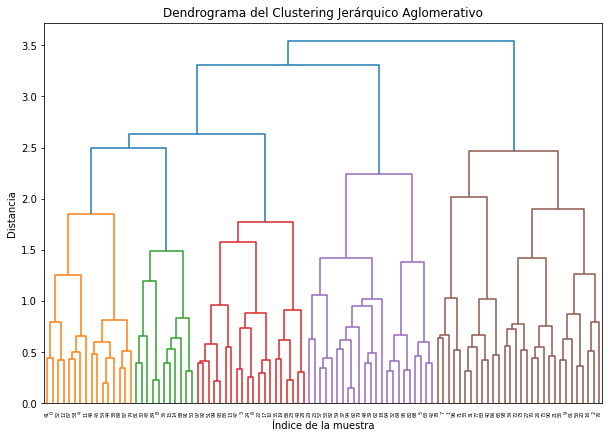

In [5]:

# Simulando un DataFrame con datos aleatorios
np.random.seed(42)  # Para reproducibilidad
data = np.random.rand(100, 6)  # 100 muestras, 4 características
df = pd.DataFrame(data, columns=['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6'])

# Realizando el clustering jerárquico aglomerativo
linked = linkage(df, method='ward')

# Creando el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrograma del Clustering Jerárquico Aglomerativo')
plt.xlabel('Índice de la muestra')
plt.ylabel('Distancia')
plt.show()

